# Kesten Processes and Firm Dynamics


<a id='index-0'></a>

# GPU

This lecture was built using a machine with JAX installed and access to a GPU.

To run this lecture on [Google Colab](https://colab.research.google.com/), click on the “play” icon top right, select Colab, and set the runtime environment to include a GPU.

To run this lecture on your own machine, you need to install [Google JAX](https://github.com/google/jax).

In addition to JAX and Anaconda, this lecture will need the following libraries:

In [2]:
!pip install quantecon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.7/322.7 kB 8.2 MB/s eta 0:00:00


## Overview

This lecture describes Kesten processes, which are an important class of
stochastic processes, and an application of firm dynamics.

The lecture draws on [an earlier QuantEcon
lecture](https://python.quantecon.org/kesten_processes.html), which uses Numba
to accelerate the computations.

In that earlier lecture you can find a more detailed discussion of the concepts involved.

This lecture focuses on implementing the same computations in JAX.

Let’s start with some imports:

In [3]:
import matplotlib.pyplot as plt
import quantecon as qe
import jax
import jax.numpy as jnp
from jax import random
from jax import lax

Let’s check the GPU we are running

In [4]:
!nvidia-smi

Mon Mar 17 13:27:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Kesten processes


<a id='index-1'></a>
A **Kesten process** is a stochastic process of the form


<a id='equation-kesproc'></a>
$$
X_{t+1} = a_{t+1} X_t + \eta_{t+1} \tag{6.1}
$$

where $ \{a_t\}_{t \geq 1} $ and $ \{\eta_t\}_{t \geq 1} $ are IID
sequences.

We are interested in the dynamics of $ \{X_t\}_{t \geq 0} $ when $ X_0 $ is given.

We will focus on the nonnegative scalar case, where $ X_t $ takes values in $ \mathbb R_+ $.

In particular, we will assume that

- the initial condition $ X_0 $ is nonnegative,  
- $ \{a_t\}_{t \geq 1} $ is a nonnegative IID stochastic process and  
- $ \{\eta_t\}_{t \geq 1} $ is another nonnegative IID stochastic process, independent of the first.  

### Application: firm dynamics

In this section we apply Kesten process theory to the study of firm dynamics.

#### Gibrat’s law

It was postulated many years ago by Robert Gibrat that firm size evolves
according to a simple rule whereby size next period is proportional to current
size.

This is now known as [Gibrat’s law of proportional growth](https://en.wikipedia.org/wiki/Gibrat%27s_law).

We can express this idea by stating that a suitably defined measure
$ s_t $ of firm size obeys


<a id='equation-firm-dynam-gb'></a>
$$
\frac{s_{t+1}}{s_t} = a_{t+1} \tag{6.2}
$$

for some positive IID sequence $ \{a_t\} $.

Subsequent empirical research has shown that this specification is not accurate,
particularly for small firms.

However, we can get close to the data by modifying [(6.2)](#equation-firm-dynam-gb) to


<a id='equation-firm-dynam'></a>
$$
s_{t+1} = a_{t+1} s_t + b_{t+1} \tag{6.3}
$$

where $ \{a_t\} $ and $ \{b_t\} $ are both IID and independent of each
other.

We now study the implications of this specification.

#### Heavy tails

If the conditions of the [Kesten–Goldie
Theorem](https://python.quantecon.org/kesten_processes.html#the-kestengoldie-theorem)
are satisfied, then [(6.3)](#equation-firm-dynam) implies that the firm size distribution
will have Pareto tails.

This matches empirical findings across many data sets.

But there is another unrealistic aspect of the firm dynamics specified in [(6.3)](#equation-firm-dynam) that we need to address: it ignores **entry and exit**.

In any given period and in any given market, we observe significant numbers of
firms entering and exiting the market.

In this setting, firm dynamics can be expressed as


<a id='equation-firm-dynam-ee'></a>
$$
s_{t+1} = e_{t+1} \mathbb{1}\{s_t < \bar s\} +
    (a_{t+1} s_t + b_{t+1}) \mathbb{1}\{s_t \geq \bar s\} \tag{6.4}
$$

The motivation behind and interpretation of [(6.4)](#equation-firm-dynam-ee) can be found in
[our earlier Kesten process lecture](https://python.quantecon.org/kesten_processes.html).

What can we say about dynamics?

Although [(6.4)](#equation-firm-dynam-ee) is not a Kesten process, it does update in the
same way as a Kesten process when $ s_t $ is large.

So perhaps its stationary distribution still has Pareto tails?

We can investigate this question via simulation and rank-size plots.

The approach will be to

1. generate $ M $ draws of $ s_T $ when $ M $ and $ T $ are
  large and  
1. plot the largest 1,000 of the resulting draws in a rank-size plot.  


(The distribution of $ s_T $ will be close to the stationary distribution
when $ T $ is large.)

In the simulation, we assume that each of $ a_t, b_t $ and $ e_t $ is lognormal.

Here’s code to update a cross-section of firms according to the dynamics in
[(6.4)](#equation-firm-dynam-ee).

In [16]:
@jax.jit
def update_s(s, s_bar, a_random, b_random, e_random):
    exp_a = jnp.exp(a_random)
    exp_b = jnp.exp(b_random)
    exp_e = jnp.exp(e_random)

    s = jnp.where(s < s_bar,
                  exp_e,
                  exp_a * s + exp_b)

    return s

Now we write a for loop that repeatedly calls this function, to push a
cross-section of firms forward in time.

For sufficiently large `T`, the cross-section it returns (the cross-section at
time `T`) corresponds to firm size distribution in (approximate) equilibrium.

In [13]:
def generate_draws(M=1_000_000,
                   μ_a=-0.5,
                   σ_a=0.1,
                   μ_b=0.0,
                   σ_b=0.5,
                   μ_e=0.0,
                   σ_e=0.5,
                   s_bar=1.0,
                   T=500,
                   s_init=1.0,
                   seed=123):

    key = random.PRNGKey(seed)

    # Initialize the array of s values with the initial value
    s = jnp.full((M, ), s_init) #创建一个大小为 M 的数组，所有元素初始值为sint

    # Perform updates on s for time t
    for t in range(T):
        keys = random.split(key, 3)
          # JAX 不能像 NumPy 那样直接调用 randn()，必须通过 random.split() 生成新随机数种子。
          # random.split(key, 3) 拆分当前 key，生成 3 个新的随机数种子
        a_random = μ_a + σ_a * random.normal(keys[0], (M, ))
        b_random = μ_b + σ_b * random.normal(keys[1], (M, ))
        e_random = μ_e + σ_e * random.normal(keys[2], (M, ))

        s = update_s(s, s_bar, a_random, b_random, e_random)

        # Generate new key for the next iteration
        key = random.fold_in(key, t)
          # JAX 不允许 key 变量被多次使用，所以每次循环都要生成新的 key。
          # random.fold_in(key, t) 保证每次循环的随机性，同时保持可复现性。

    return s

%time data = generate_draws().block_until_ready()

NameError: name 'update_s' is not defined

Running the above function again so we can see the speed with and without compile time.

In [6]:
%time data = generate_draws().block_until_ready()

CPU times: user 3.38 s, sys: 942 ms, total: 4.32 s
Wall time: 2.89 s


Notice that we do not JIT-compile the `for` loops, since

1. acceleration of the outer loop makes little difference terms of compute
  time and  
1. compiling the outer loop is often very slow.  


Let’s produce the rank-size plot and check the distribution:

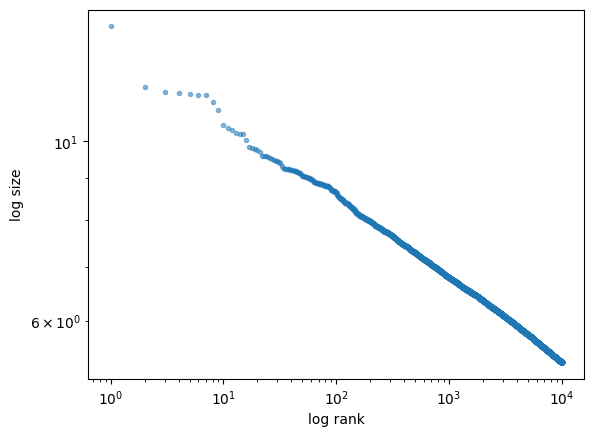

In [7]:
fig, ax = plt.subplots() #ax：表示 子图（axes）。

rank_data, size_data = qe.rank_size(data, c=0.01)
ax.loglog(rank_data, size_data, 'o', markersize=3.0, alpha=0.5)
ax.set_xlabel("log rank")
ax.set_ylabel("log size")

plt.show()

如果公司规模分布 符合 Pareto 分布，则 Rank-Size 图在 log-log 坐标下应该近似为一条直线

The plot produces a straight line, consistent with a Pareto tail.

#### Alternative implementation with `lax.fori_loop`

If the time horizon is not too large, we can try to further accelerate our code
by replacing the `for` loop with
[`lax.fori_loop`](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.fori_loop.html).

Note, however, that

1. as mentioned above, there is not much speed gain in accelerating outer loops,  
1. `lax.fori_loop` has a more complicated syntax, and, most importantly,  
1. the `lax.fori_loop` implementation consumes far more memory, as we need to have to
  store large matrices of random draws  


Hence the code below will fail due to out-of-memory errors when `T` and `M` are large.

Here is the `lax.fori_loop` version:

jax.lax.fori_loop 是 JAX 的 函数式循环优化工具：



lax.fori_loop(start, stop, body_fun, init_val)

- start：循环开始值（类似 range(start, stop)）。
- stop：循环结束值。
- body_fun(i, carry)：
- i 是当前迭代步。
- carry 是累积变量，在每次循环时更新。
- init_val：初始值。

优点：

适用于 GPU/TPU 计算，加速 for 循环。
在 JIT 编译时优化性能。


缺点：

内存占用大，可能导致 OOM。
代码复杂度增加。

In [12]:
@jax.jit
def generate_draws_lax(μ_a=-0.5,
                       σ_a=0.1,
                       μ_b=0.0,
                       σ_b=0.5,
                       μ_e=0.0,
                       σ_e=0.5,
                       s_bar=1.0,
                       T=500,
                       M=500_000,
                       s_init=1.0,
                       seed=123):

    key = random.PRNGKey(seed)
    keys = random.split(key, 3)

    # Generate random draws and initial values
    a_random = μ_a + σ_a * random.normal(keys[0], (T, M))
    b_random = μ_b + σ_b * random.normal(keys[1], (T, M))
    e_random = μ_e + σ_e * random.normal(keys[2], (T, M))
    s = jnp.full((M, ), s_init)

    # Define the function for each update
    def update_s(i, s):
        a, b, e = a_random[i], b_random[i], e_random[i]
        s = jnp.where(s < s_bar,
                      jnp.exp(e),
                      jnp.exp(a) * s + jnp.exp(b))
        return s

    # Use lax.scan to perform the calculations on all states
    s_final = lax.fori_loop(0, T, update_s, s)
    return s_final

%time data = generate_draws_lax().block_until_ready()

CPU times: user 1.13 s, sys: 45.2 ms, total: 1.18 s
Wall time: 1.18 s


In this case, `M` is small enough for the code to run and
we see some speed gain over the for loop implementation:

In [6]:
%time data = generate_draws_lax().block_until_ready()

CPU times: user 5.73 ms, sys: 0 ns, total: 5.73 ms
Wall time: 79 ms


Here we produce the same rank-size plot:

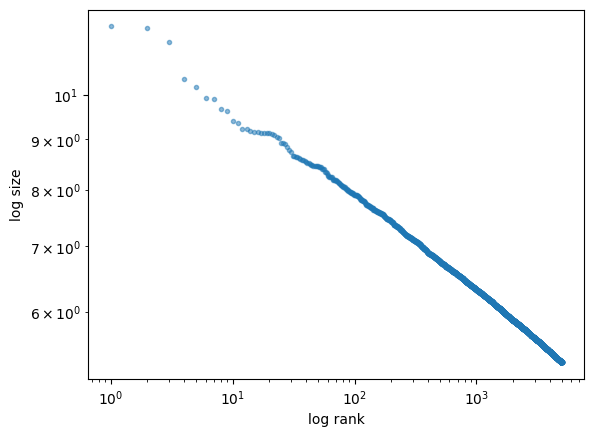

In [7]:
fig, ax = plt.subplots()

rank_data, size_data = qe.rank_size(data, c=0.01)
ax.loglog(rank_data, size_data, 'o', markersize=3.0, alpha=0.5)
ax.set_xlabel("log rank")
ax.set_ylabel("log size")

plt.show()

Let’s rerun the `for` loop version on smaller `M` to compare the speed

In [17]:
%time generate_draws(M=500_000).block_until_ready()

CPU times: user 3.62 s, sys: 836 ms, total: 4.45 s
Wall time: 2.85 s


Array([1.8281046, 2.8847322, 2.3919296, ..., 2.9062161, 4.1978517,
       2.1926358], dtype=float32)

Let’s run it again to get rid of the compile time.

In [18]:
%time generate_draws(M=500_000).block_until_ready()

CPU times: user 3.33 s, sys: 838 ms, total: 4.16 s
Wall time: 2.57 s


Array([1.8281046, 2.8847322, 2.3919296, ..., 2.9062161, 4.1978517,
       2.1926358], dtype=float32)

We see that the `lax.fori_loop` version is faster than the `for` loop version
when memory is not an issue.